In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

from src.models.features import CreditScoreTransformer, BalanceTransformer, AgeTransformer, RatioTransformer
from src.models.evaluate import eval_PR, cv_confusion_matrix, confusion_matrix_df

In [3]:
# Ignore the specific warning about penalty=None
warnings.filterwarnings('ignore', message="Setting penalty=None will ignore the C and l1_ratio parameters")

In [4]:
# Set directory paths
project_root_dir = Path('../')

In [5]:
# Load clean data and create train test split
try:
    train = pd.read_csv(project_root_dir/ 'data/clean/train.csv')
    X = train.drop(['Exited'], axis=1)
    y = train['Exited']
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Rerun previous notebook first.")

# Model Development
In this section we will start building a predictive model for predicting customer churn. Due to the imbalanced ratio of the positive (churn) vs negative class (not churn), we will use average precision or AUC-PR as it is a more robust metric of performance in this case. In addition we will use 5-fold cross-validation when computing all of our metrics in order to reduce overfitting, in particular we will use the same folds for consistency. 

In [6]:
# Setup
shared_cv = StratifiedKFold(shuffle=True, random_state=42)

print(f"Baseline churn rate: {100*y.mean():.2f}%")

models = []
models_name = []

Baseline churn rate: 20.38%


## Model 0 - Baseline
- Logistic Regression Model with no regularization and class weights
- Applied standardization for numerical features
- Applied one hot encoding for categorical/binned features

In [7]:
# Baseline Logistic Regression Model
model_0 = Pipeline([
    (
        'processor',
        ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), 
                 ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
                 ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])
            ]
        )
    ),
    (
        'classifier',
        LogisticRegression(
            C=np.inf, 
            class_weight='balanced', 
            solver='lbfgs', 
            max_iter=10000
        )
    )
])

models.append(model_0)
models_name.append('Model 0')

# Compute cross-validated confusion matrix and PR curve for baseline model
display(cv_confusion_matrix(model_0, X, y, shared_cv))

Cross-validated Metrics:
Precision: 0.3799
Recall: 0.6859
F1 Score: 0.4890


,Predicted Negative,Predicted Positive
Actual Negative,4545,1825
Actual Positive,512,1118


## Model 0.1 - Baseline + distribution-aware processing
From our exploratory data analysis we found that Age, Balance, CreditScore, and EstimatedSalary were not normally distributed. In particular we had that:
- Age was right skewed with rounding spikes at multiples of 10
- Balance had a zero-inflated normal distribution
- CreditScore had a right censored normal distribution
- EstimatedSalary was evenly distributed

With this in mind we will perform the following techniques to account for these features:
- Age: Flag spikes and log transform
- Balance: Flag zero-balance and masked scale
- CreditScore: Flag max and robust scale
- EstimatedSalary: min-max scale

In [8]:
processor_01 = ColumnTransformer(
    [
        # Numerical Features
        ('Age', AgeTransformer(), ['Age']),
        ('Balance', BalanceTransformer(), ['Balance']),
        ('CreditScore', CreditScoreTransformer(), ['CreditScore']),
        ('EstimatedSalary', MinMaxScaler(), ['EstimatedSalary']),
        # Categorical Features
        (
            'OHEnc', 
            OneHotEncoder(dtype='int', sparse_output=False, drop='first'),
            ['Geography', 'Gender', 'NumOfProducts']
        ),
        ('passthrough', 'passthrough', ['HasCrCard', 'IsActiveMember'])
    ],
    remainder='drop', verbose_feature_names_out=False
)

model_01 = Pipeline([
    ('processor', processor_01),
    ('classifier', LogisticRegression(C=np.inf, class_weight='balanced', solver='lbfgs', max_iter=10000))
])

models.append(model_01)
models_name.append('Model 0.1')

display(cv_confusion_matrix(model_01, X, y, shared_cv))

Cross-validated Metrics:
Precision: 0.4523
Recall: 0.7540
F1 Score: 0.5654


,Predicted Negative,Predicted Positive
Actual Negative,4882,1488
Actual Positive,401,1229


Cross-validated Metrics:
Precision: 0.4523
Recall: 0.7540
F1 Score: 0.5654

## Model 0.1.1 - Baseline + distribution-aware processing + interaction features
We now attempt to capture non-linear interactions between the features of the form feature_1xfeature_2. Furthermore we will use regularization in order to account for the resulting increase in the number of features.

In [9]:
processor_011 = Pipeline([
    ('processor', processor_01),
    ('interactions', PolynomialFeatures(degree=2, include_bias=False))
])

model_011 = Pipeline([
    ('processor', processor_011),
    ('classifier', LogisticRegression(
        C=1,
        l1_ratio = 1,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

models.append(model_011)
models_name.append('Model 0.1.1')

display(cv_confusion_matrix(model_011, X, y, shared_cv))

Cross-validated Metrics:
Precision: 0.4641
Recall: 0.7497
F1 Score: 0.5733


,Predicted Negative,Predicted Positive
Actual Negative,4959,1411
Actual Positive,408,1222


## Model 1 - Tree Model
- Gradient Boosted Trees
- Apply one hot encoding to to categorical features (Geography, Gender)
- No scaling of numerical features

In [10]:
processor_1 = ColumnTransformer(
    [
        (
            'OHEnc', 
            OneHotEncoder(dtype='int', sparse_output=False, drop='first'),
            ['Geography', 'Gender']
        )
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

model_1 = Pipeline([
    ('processor', processor_1),
    ('classifier', XGBClassifier(
        n_estimators = 1000,
        max_depth = 4,
        learning_rate = 0.05,
        scale_pos_weight=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,

    ))
])

models.append(model_1)
models_name.append('Model 1')

display(cv_confusion_matrix(model_1, X, y, shared_cv))

Cross-validated Metrics:
Precision: 0.5450
Recall: 0.6534
F1 Score: 0.5943


,Predicted Negative,Predicted Positive
Actual Negative,5481,889
Actual Positive,565,1065


## Model 1.1 - Tree Model + Ratio Features

In [11]:
processor_11 = ColumnTransformer(
    [
        ('OHEnc', OneHotEncoder(dtype='int', sparse_output=False, drop='first'), ['Geography', 'Gender']),
        ('ratio', RatioTransformer(), ['CreditScore', 'Age', 'EstimatedSalary', 'Balance'])
    ], 
    remainder='passthrough', verbose_feature_names_out=False
)

model_11 = Pipeline([
    ('processor', processor_11),
    ('classifier', XGBClassifier(
        n_estimators = 1000,
        max_depth = 4,
        learning_rate = 0.05,
        scale_pos_weight=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ))
])

models.append(model_11)
models_name.append("Model 1.1")

display(cv_confusion_matrix(model_11, X, y, shared_cv))

Cross-validated Metrics:
Precision: 0.5601
Recall: 0.6515
F1 Score: 0.6024


,Predicted Negative,Predicted Positive
Actual Negative,5536,834
Actual Positive,568,1062


## Model Selection

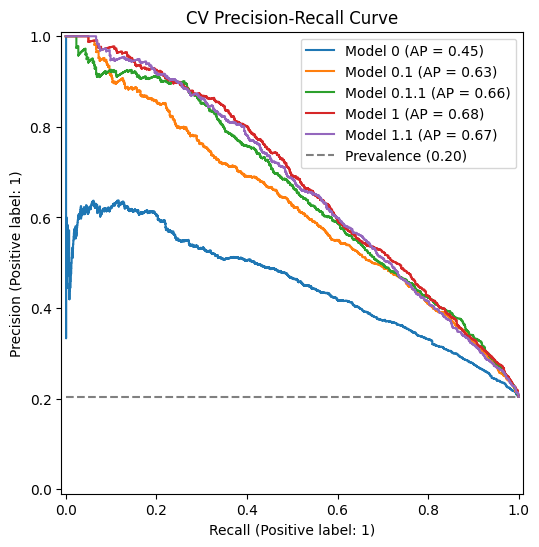

In [12]:
# Model Performance
eval_PR(X, y, pipeline=models, cv=shared_cv, name=models_name)

We choose Model 1 (Baseline Tree) as our final model as it had the best performance out of all the other iterations. In addition the best linear model is no longer an easily explainable model due to the complex feature engineering and hence should not be chosen when it has an approximately 4% drop in predictive power.

Furthermore we will tune the model's hyperparameters in order to squeeze out some performance improvements.

In [13]:
# Tune hyperparameters
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__scale_pos_weight': [1, 2, 3, 4]
}

model_grid = GridSearchCV(
    estimator=model_1,
    param_grid=param_grid,
    cv=shared_cv,
    scoring='average_precision',
    n_jobs=-1
)

model_grid.fit(X, y)

display(model_grid.best_params_)
final_model = model_grid.best_estimator_

{'classifier__learning_rate': 0.2,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__scale_pos_weight': 3,
 'classifier__subsample': 1.0}

Cross-validated Metrics:
Precision: 0.5672
Recall: 0.6883
F1 Score: 0.6220


,Predicted Negative,Predicted Positive
Actual Negative,5514,856
Actual Positive,508,1122


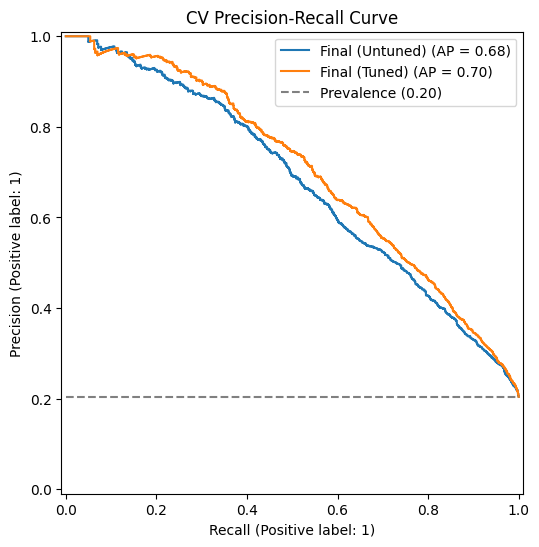

In [14]:
models.append(final_model)
models_name.append('Final Model (Tuned)')

display(cv_confusion_matrix(final_model, X, y, shared_cv))
eval_PR(X, y, [model_1, final_model], shared_cv, name=['Final (Untuned)', 'Final (Tuned)'])

# Final Model Evaluation
In this section we will evaluate the performance of this model on our test set to estimate the model's performance on unseen data.

In [15]:
# Get Test set and predict classes and probabilities.
test = pd.read_csv(project_root_dir / 'data/clean/test.csv')
X_test, y_test = test.drop(['Exited'], axis=1), test['Exited']

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

,Predicted Negative,Predicted Positive
Actual Negative,1374,219
Actual Positive,122,285


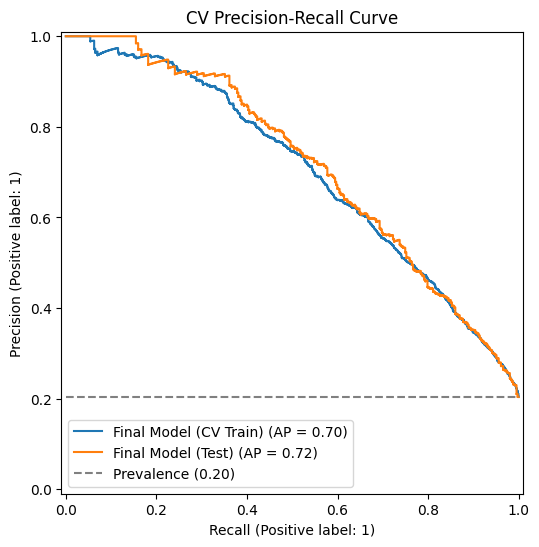

In [16]:
display(confusion_matrix_df(y_test, y_pred))
eval_PR(X, y, [final_model], shared_cv, name=['Final Model (CV Train)'],
        final_pipeline=final_model, X_final=X_test, y_final=y_test, name_final='Final Model (Test)')

**Observations**
- Our final model performed better on the test set compared to when we estimated its performance using cross-validation on the training set.
- From the Precision-Recall curve plot, we see that our model consistently outperforms all the other models at almost all levels of recall.
- In addition we see that our model perfectly predicts the top ~15% of churners with 100% precision. Furthermore we do not start seeing a large trade-off between recall and precision until we reach a recall of ~37.5% in which case we are still accurately predicting churners at a rate of ~90%.